In [1]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

Setting up some global variables -

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAX_LENGTH`: Maximum length of all sequences. Defaults to 32.

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9

- `BATCH_SIZE`: Batch size. Defaults to 128

In [2]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
BATCH_SIZE = 128

In [3]:
data_path = "./data/twitter_1.6m_dataset.csv"
df = pd.read_csv(data_path, header=None, encoding="Windows-1252")
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Standardize labels so they have 0 for negative and 1 for positive
labels = df[0].apply(lambda x: 0 if x == 0 else 1).to_numpy()

# Since the original dataset does not provide headers you need to index the columns by their index
sentences = df[5].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 1600000 examples

Text of second example look like this: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Labels of first 5 examples look like this: [0, 0, 0, 0, 0]


In [5]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets(dataset):
    """
    Splits the dataset into training and validation sets, after shuffling it.
    
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with elements as (sentence, label)
    
    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    """   
    ### START CODE HERE ###
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(dataset) * TRAINING_SPLIT)

    # Split the sentences and labels into train/validation splits
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Turn the dataset into a batched dataset with BATCH_SIZE elements each.
    train_dataset = train_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)

    ### END CODE HERE ###
    
    return train_dataset, validation_dataset

In [6]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {BATCH_SIZE*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {BATCH_SIZE*len(validation_dataset)} elements for validation.\n")

There are 11250 batches for a total of 1440000 elements for training.

There are 1250 batches for a total of 160000 elements for validation.



In [9]:
for values in train_dataset.take(1):
    print(values)

(<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       b"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       b'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       b'my whole body feels itchy and like its on fire ',
       b"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
       b'@Kwesidei not the whole crew ', b'Need a hug ',
       b"@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
       b"@Tatiana_K nope they didn't have it ",
       b'@twittera que me muera ? ',
       b"spring break in plain city... it's snowing ",
       b'I just re-pierced my ears ',
       b"@caregiving I couldn't bear to watch it.  And I thought the UA l

In [10]:
# GRADED FUNCTION: fit_vectorizer

def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences
    
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.
    
    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """    

    ### START CODE HERE ###
    
    # Instantiate the TextVectorization class, defining the necessary arguments alongside their corresponding values
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=None,  # Let the layer learn the vocabulary size
        output_mode='int',
        output_sequence_length=MAX_LENGTH,
        standardize='lower_and_strip_punctuation'  # Convert to lowercase and remove punctuation
    ) 
    
    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)
    
    
    
    ### END CODE HERE ###
    
    return vectorizer

In [11]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 778125 words



In [12]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

In [20]:


# Define path to file containing the embeddings
glove_file = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file, encoding="utf-8", errors="replace") as f:
    for line in f:
        values = line.strip().split()
        if len(values) < 101:
            continue
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = coefs
        except ValueError:
            continue


In [21]:
test_word = 'dog'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [22]:
test_word = 'hewlett'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word hewlett looks like this:

[-0.12851   0.31182  -0.56978   0.13511   0.32281  -0.81703   0.63655
 -1.0507   -0.15281  -0.82062   0.82195  -0.011347  0.25064  -0.75278
 -0.48916  -0.43175   0.29134   0.3514    0.38409   0.33224  -0.48183
 -0.14542   0.64383   1.6313    0.33512   0.033127  0.039672 -0.04332
 -0.71606  -0.3664    1.0265    0.82588  -0.22387  -0.63676  -0.22589
  0.79912   0.52802  -0.30399   1.2736   -0.16677  -0.50177  -0.31462
 -0.44086  -0.23376  -1.0294    0.85435  -0.01148   0.057158  0.69292
 -0.18117   0.039837 -0.86168  -0.67197  -0.067808 -0.2916   -0.74744
  0.053889 -0.033064  0.19298  -0.63739  -0.30188  -0.14898  -0.35906
  0.67043  -1.2153   -0.71682   0.71228   0.72294   0.061824  0.67716
  0.11703   0.83398  -0.87826  -0.67405  -0.54951  -0.23612   0.43482
 -0.24531  -0.3427    0.5438    0.79007  -0.12483  -0.37619   0.43734
 -1.401    -0.46087   0.71468   0.007626  0.7855   -0.25982   0.69957
  0.30976   0.24053   0.75945   0.

In [23]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [24]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

print(f"The word dog is encoded as: {word_index['dog']}")

The word dog is encoded as: 495


In [25]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [26]:
test_word = 'dog'

test_word_id = word_index[test_word]

test_vector_dog = glove_embeddings[test_word]

test_embedding_dog = embeddings_matrix[test_word_id]

both_equal = np.allclose(test_vector_dog,test_embedding_dog)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: dog, index: 495

Embedding is equal to column 495 in the embeddings_matrix: True


In [27]:
# GRADED FUNCTION: create_model

def create_model(vocab_size, pretrained_embeddings):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): Number of words in the vocabulary.
        pretrained_embeddings (np.ndarray): Array containing pre-trained embeddings.

    Returns:
        (tf.keras Model): the sentiment classifier model
    """
    ### START CODE HERE ###
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(None,)),  # Input layer for variable-length sequences
        tf.keras.layers.Embedding(
            input_dim=vocab_size,          # Vocabulary size
            output_dim=pretrained_embeddings.shape[1],  # Embedding dimension
            weights=[pretrained_embeddings],
            trainable=False               # Pre-trained embeddings are frozen
        ),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),  # Convolutional layer
        tf.keras.layers.GlobalMaxPooling1D(),                                   # Global max pooling
        tf.keras.layers.Dropout(0.5),                                           # Dropout to mitigate overfitting
        tf.keras.layers.Dense(28, activation='relu'),                           # Fully connected hidden layer
        tf.keras.layers.Dense(1, activation='sigmoid')                          # Output layer for binary classification
    ])

    model.compile(
        loss='binary_crossentropy',  # Loss function for binary classification
        optimizer='adam',            # Optimizer
        metrics=['accuracy']         # Metric to monitor during training
    )

    ### END CODE HERE ###

    return model

In [28]:
# Create your untrained model
model = create_model(vocab_size, embeddings_matrix)

In [29]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 1)


In [30]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized, 
	epochs=10, 
	validation_data=validation_dataset_vectorized
)

Epoch 1/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9996 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 1.5095e-06
Epoch 2/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9865 - loss: 0.4946 - val_accuracy: 1.0000 - val_loss: 4.1616e-06
Epoch 3/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9877 - loss: 0.2759 - val_accuracy: 1.0000 - val_loss: 1.0216e-06
Epoch 4/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9850 - loss: 0.3818 - val_accuracy: 1.0000 - val_loss: 8.8919e-07
Epoch 5/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9856 - loss: 0.3118 - val_accuracy: 1.0000 - val_loss: 3.8802e-06
Epoch 6/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9868 - loss: 0.2069 - val_accuracy: 1.0000 - val_loss: 1.8199e-07
Epoch 7/10
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9861 - loss: 0.2514 - val_accuracy: 1.0000 - val_loss: 3.9832e-07
Epoch 8/10
11250/11250 ━━━━━━━━━━━━━━━━━━

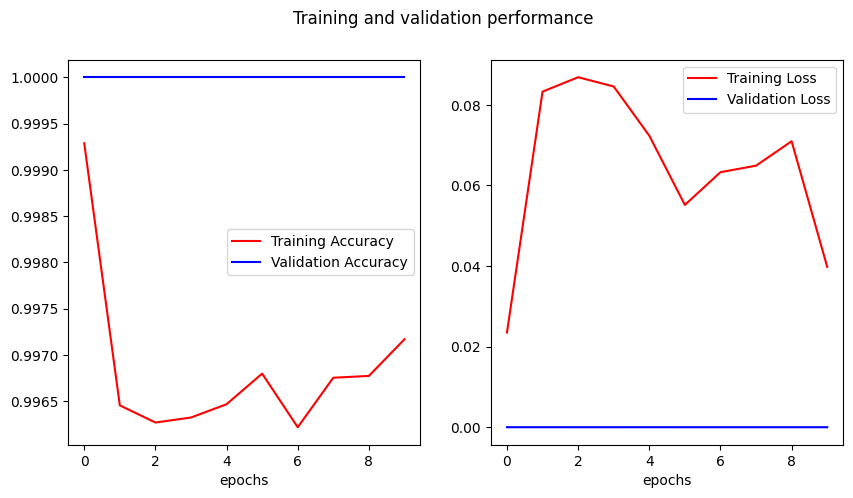

In [31]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

In [32]:
with open('sentiment_analysis_training.pkl', 'wb') as f:
    pickle.dump(history.history, f)